Week 2 Challenge: A/B Hypothesis Testing: Ad campaign performance 

  Objective:

The main objective of this project is to test if the ads that the advertising company runs resulted in a significant lift in brand awareness. 

In [57]:
# importing Packages
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
from scipy import stats


In [3]:
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)


In [61]:
# taking a csv file path and reading a dataframe

def read_proccessed_data(csv_path):
    try:    
        db = pd.read_csv(csv_path)
        print("file read as csv")
        return db.head()
    except FileNotFoundError:
        print("file not found")
read_proccessed_data('../Data/AdSmartABdata.csv')

file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


 Data Understanding

In [4]:
db.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [5]:
# size of the data
db.size

72693

In [6]:
db.shape

(8077, 9)

In [7]:
# data type of the data frame
db.dtypes

auction_id     object
experiment     object
date           object
hour            int64
device_make    object
platform_os     int64
browser        object
yes             int64
no              int64
dtype: object

In [8]:
db['date'] = pd.to_datetime(db['date'])

Task 1.2 Classic and sequential A/B testing analysis

In [9]:
# Data exploration
# printing number of unique values and unique values
print('The number of unique devices: ', db['device_make'].nunique())
print('Unique Browsers: ', db['browser'].unique())
print('platform_os: ', db['platform_os'].unique())


The number of unique devices:  270
Unique Browsers:  ['Chrome Mobile' 'Chrome Mobile WebView' 'Facebook' 'Mobile Safari'
 'Chrome Mobile iOS' 'Samsung Internet' 'Mobile Safari UI/WKWebView'
 'Chrome' 'Opera Mini' 'Edge Mobile' 'Android' 'Pinterest' 'Opera Mobile'
 'Firefox Mobile' 'Puffin']
platform_os:  [6 5 7]


In [10]:
# checking if missing values are there
db.isnull().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [63]:
# plotting functions
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    plt.figure(figsize=(9, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    
def plot_dist(df:pd.DataFrame, column:str):
    plt.figure(figsize=(9,7))
    sns.distplot(df).set_title(f'Distribution of {column}')
    


def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Plot count of {column}', size=20, fontweight='bold')
    plt.xticks(rotation=70)
    
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    
def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)

def plot_counttwo(df,col1,col2):
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    sns.countplot(data=df, x=col1,palette='summer')
    plt.title(f'Distribution of {col1}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    
    plt.subplot(1,2,2)
    sns.countplot(data=df, x=col2,palette='summer_r')
    plt.title(f'Distribution of {col2}', size=16, fontweight='bold')
    plt.xticks(rotation=70)
    plt.show()

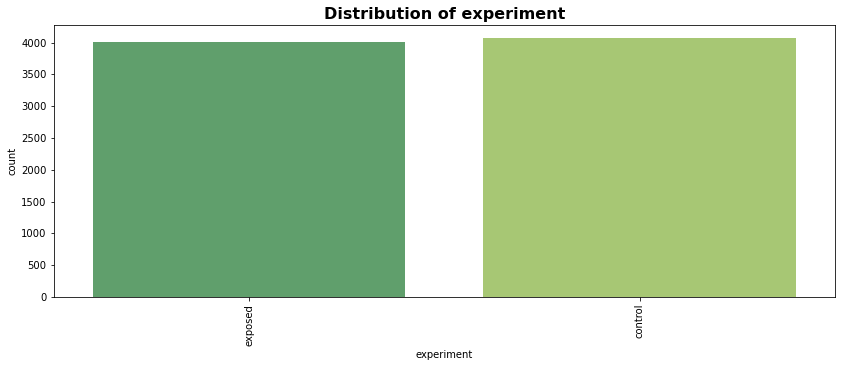

In [13]:
# plotting the experiment column
plot_count(db,'experiment')

**As we can see from the figure the online users are equally distributed to the exposed and control groups.**  

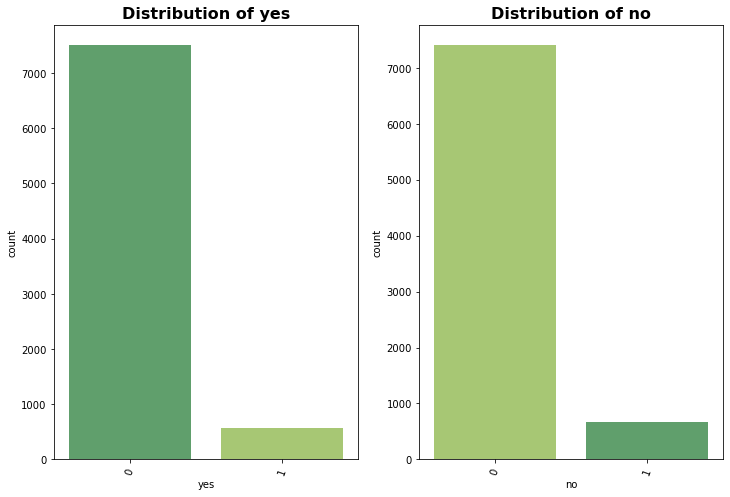

In [33]:
plot_counttwo(db,'yes','no')

**As we can see from the figure most of the users did not answer the questions.**

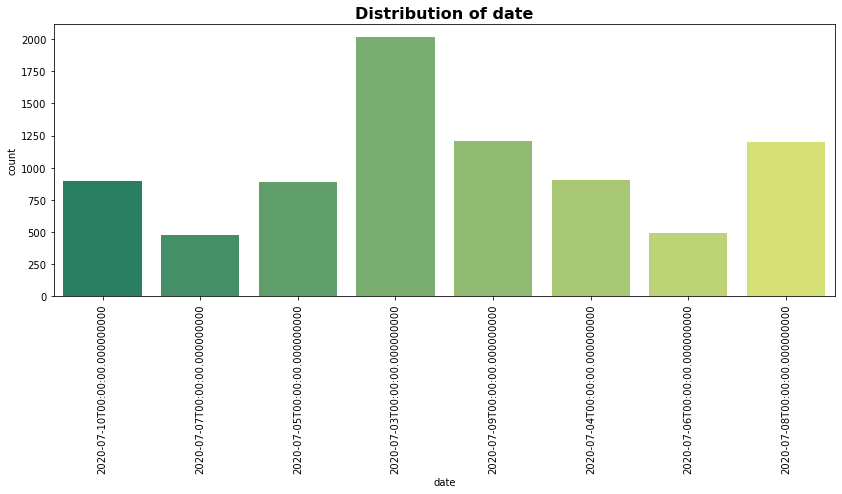

In [21]:
plot_count(db, 'date')

**As we can see from the figure most of the users has engaged with the question at the first day.**

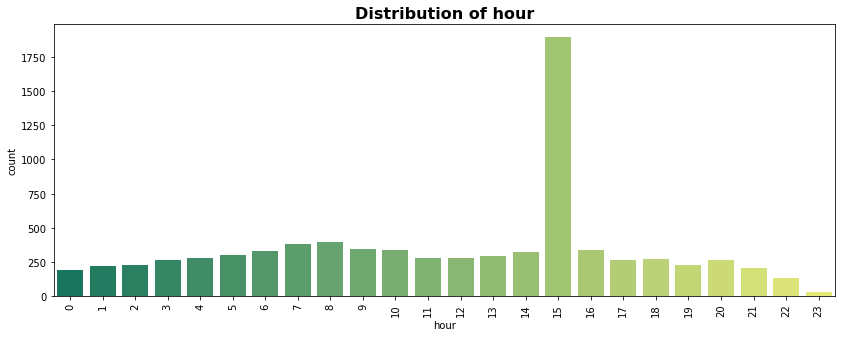

In [23]:
plot_count(db, 'hour')

**Most of the users were engaged to the question around 12pm UTc**

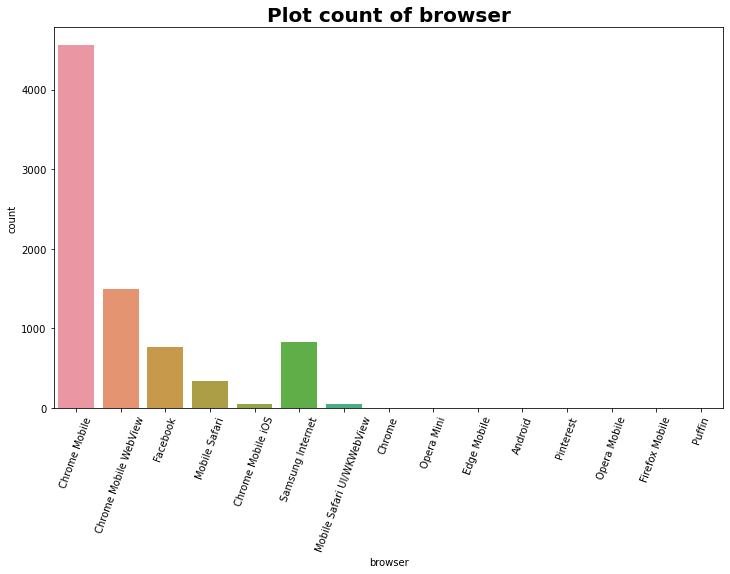

In [64]:
plot_count(db, 'browser')

Most of the users uses chrome mobile

**Hypothesis testing**

**To perform hypothesis testing there are many rows that does not have 1 in either yes or no columns.**
* let us see if this types of users are evenly distributed to the groups

In [52]:
# locating the rows which have control and which have exposed
control = db.loc[db['experiment'] == 'control']
exposed = db.loc[db['experiment'] == 'exposed']

In [53]:
# locating the rows for both of groups for whom the users  did not answer the question
control_unanswered = db.loc[(db['yes'] == 0) & (db['no'] == 0) & (db['experiment'] == 'control')]
exposed_unanswered = db.loc[(db['yes'] == 0) & (db['no'] == 0) & (db['experiment'] == 'exposed')]

In [54]:
# finding the percent of the users who did not answer for control group
control_unanswered.shape[0]/control.shape[0] * 100

85.60550233357898

In [55]:
# finding the percent of the users who did not answer for exposed group
exposed_unanswered.shape[0]/exposed.shape[0] * 100

83.59960059910134

**The number of the users that did not answer the question for both of the group are almost similar so if we drop those rows it will not affect our analysis.**

In [17]:
newdb = db.drop(db[(db['yes'] ==0) &(db['no']==0)].index)
newdb.shape

(1243, 9)

* <h2>Based on the above plots the exposed group seems to have more counts of yes than the exposed group.But We can not conclude based on the difference only that the SmartAd increased brand awareness<h2>

<h1> Classical testing analysis</h1>

<h2>Performing hypothesis testing: For hypothesis testing we need to have two sample hypothesis which are the Null hypothesis and the Alternative hypothesis, the hypothesis are as follows</h2>

**Null hypothesis:** there is no significant difference in brand awareness between the exposed and control groups it is just natural variance

**Alternate hypothesis:** there is a significant difference in brand awareness between the exposed and control groups 

* To reject our null hypothesis, we have to prove that there is a statistically significant difference 

* Given that the outcome of the questionnaire is binary, we use the chi-square test method to check whether the differences of the control and experiment groups were significant
- from the bussiness perspective lets say a 2% brand awarenes increase would be practically significant.dmin=0.02
- and have a confidence level of 95%

*If d>1.96SEpool or d<-1.96SEpool Reject the null

In [66]:
newdb.shape

(1243, 9)

In [76]:
#Creating a table with a summary of the observed outcomes
df=newdb.groupby('experiment').agg({'yes':'sum','no':'sum'})
df.loc[:,'Total']=df.sum(axis=1)
df.head()

,yes,no,Total
experiment,,,
control,264,322,586
exposed,308,349,657


In [80]:
controlyes=df['yes'][0]
controlno=df['no'][0]
exposedyes=df['yes'][1]
exposedno=df['no'][1]
TOtalcontrol = df['Total'][0]
TOtalexposed = df['Total'][1]

657

In [69]:
Ppool=(controlyes+exposedyes)/newdb.shape[0]
print(Ppool)

0.46017699115044247


In [81]:
import math
#Pool standard error
SEpool=math.sqrt(Ppool*(1-Ppool)*((1/TOtalcontrol)+(1/TOtalexposed)))
print(SEpool)

0.028319932727228023


In [82]:
## diference between Pexp and Pcon
d=(exposedyes/TOtalexposed)-(controlyes/TOtalcontrol)
print(d)

0.018285619295484168


In [83]:
#margin of error
m=1.96*SEpool
print(m)

0.055507068145366927


In [84]:
lowerboundary=d-m
upperboundary=d+m
print(lowerboundary,upperboundary)

-0.03722144884988276 0.0737926874408511


**From this output that we can say we dont have enough power to draw a conclusion we need more data to reach a conclusion.**